In [11]:
import time
import math

import numpy as np
import pandas as pd
from services.experiments import *
from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *

from services.environment_functions import *
from services.binary_optimization import *
from services.big_m_strategies import *

from services.plotting_functions import *
import os
Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'SP'
imputation_method = 'Multivariate'
ticker_str = 'AAPL'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [12]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [13]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('1996-11-30 00:00:00')

In [14]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [15]:

start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

# start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')
#
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)
factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [16]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [17]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [18]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [19]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [20]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [21]:
# Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs
# investor preferences (static throughout the backtest)
hyperparam_search = False # True if model has hyperparams
optimizer = CardMVO # CardMVO , MVO
estimator = exponential_weighted_estimator_shrinkage #
EstNumObs = 750
k = 6*20 #estimation horizon
alpha= 1 - 0.990 #estimation decay
return_premium = 1 #optimization premium

turnover_constraints = True
turnover_limit = 0.75 # 0.75, 1, 1.25
cardinality_ratio = 0.5 #optimization

MipGap = 0.05 # for portfolio optimizer
limit_time = 20 # for portfolio optimizer

target_return_strategy = premium_target # for portfolio optimizer to calculate return target
# mean_target, premium_target, ticker_return_target
target_return_strategy_args = ['premium'] # args for the return strategy

bigMStrategy = HyperparameterBigMStrategy #objectiveBigMStrategy #objectiveBigMStrategyTightening , objectiveBigMStrategy

bigM_limit_time=20 # for the feasible solution used to calculate big M
bigM_MipGap=0.05 # for the feasible solution used to calculate big M
bigM_SolutionLimit=20 # for the feasible solution used to calculate big <

SkipSOCP = True # flag to skip the SOCP
tightening_iter_lim = 1 # number of iterations of tightening to do

SVMMVO_bigM_time_limit = 5 # for computing a better solution in the tightening strategy
SVMMVO_MipGap=0.1 # for computing a better solution in the tightening strategy
SVMMVO_SolutionLimit=5 # for computing a better solution in the tightening strategy

SOCP_limit_time=10 # time limit for the SOCP's

ticker_index = tickers.get_loc(ticker_str) # the ticker we want to compare to if
#  we are using the ticker_return_target strategy

q = 2 #subset of features

C = 0.1 # separation importance

epsilon = 0.1 # regularization amount for SVM

separable = False # do not restrict the hyperplane to be separable

LogToConsole = True # display optimization results in the console
Verbose = True # print statements

hyperparams = {'C': list(np.geomspace(0.1, 100, 4)), 'epsilon': list(np.geomspace(0.1, 100, 4))} # hyperparams for hyperparam search
#q_alpha = 0.3187 # alpha for Q(t, a) = (1 - q_alpha) Q(t-1. a) + R(t, a)
q_alpha = 0.6838
kappa = 0.1 # 10 % risk/turnover tolerance

investor_preferences = {'k':k, # horizon
                        'alpha':alpha, # decay
                        'premium':return_premium, # return premium preference
                        'EstNumObs':EstNumObs,
                        'ticker_index':ticker_index, # benchmark index for comparison used in place of return premium depending on the investors function to set r_min
                        'target_return_strategy':target_return_strategy, # strategy for setting return
                        'target_return_strategy_args': target_return_strategy_args, # args for return setting strategy
                        'turnover_limit':turnover_limit, # turnover limit
                        'turnover_constraints':turnover_constraints, # turnover limit choice (Y/N)
                        'cardinality_ratio': cardinality_ratio, # Pct of assets to invest in
                        'MipGap' : MipGap, 'limit_time':limit_time, # problem solving limits
    
                        'bigMStrategy':bigMStrategy,
                        'bigM_limit_time':bigM_limit_time,
                        'bigM_MipGap':bigM_MipGap,
                        'bigM_SolutionLimit':bigM_SolutionLimit,

                        'SkipSOCP':SkipSOCP,
                        'tightening_iter_lim':tightening_iter_lim,

                        'SVMMVO_bigM_time_limit':SVMMVO_bigM_time_limit,
                        'SVMMVO_MipGap':SVMMVO_MipGap,
                        'SVMMVO_SolutionLimit':SVMMVO_SolutionLimit,

                        'SOCP_limit_time':SOCP_limit_time,
                        'q':q,
                        'C':C,
                        'epsilon':epsilon,
                        'separable':separable,
                        'LogToConsole':LogToConsole,
                        'Verbose':Verbose,
                        'hyperparams':hyperparams,
                        'q_alpha':q_alpha,
                        'kappa':kappa}

Strategy = general_strategy(estimator, optimizer,
                            investor_preferences = investor_preferences)

Strategy.extract_estimation_info = populate_exponential_weighted_estimator_shrinkage
Strategy.extract_optimization_info = populate_kwargs

StrategyCardMVO = general_strategy(estimator, CardMVO,
                            investor_preferences = investor_preferences)

StrategyCardMVO.extract_estimation_info = populate_exponential_weighted_estimator_shrinkage
StrategyCardMVO.extract_optimization_info = populate_kwargs

env = environment()
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [22]:

# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=2)

# End of the first investment period
# testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [23]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 1998-12-31 00:00:00
Test End 1999-05-31 00:00:00
Calibration End 1998-12-30 00:00:00


In [24]:
# Number of assets
n  = len(tickers)
env.n = n

# Measure runtime: start the clock
start_time = time.time()

# Subset the returns and factor returns corresponding to the current calibration period.
periodReturns = returns[returns.index <= calEnd]
periodFactRet = factorRet[factorRet.index <= calEnd]

# take the last available contextual observations
period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

env.periodReturns = periodReturns
env.periodFactRet = periodFactRet
env.period_daily_adjClose = period_daily_adjClose
env.period_Context = period_Context

# there should be a feature vector for each asset
assert len(period_Context) == n
# all the tickers should be aligned in the context and ticker dataset
assert (periodReturns.columns == period_Context.index).all()

current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
currentPrices = adjClose[current_price_idx]

# Subset the prices corresponding to the current out-of-sample test period.
periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
periodPrices = adjClose[periodPrices_idx]

assert len(periodPrices) == investPeriod
assert len(currentPrices) == 1

# Set the initial value of the portfolio or update the portfolio value

#----------------------------------------------------------------------
# Portfolio optimization
# You must write code your own algorithmic trading function
#----------------------------------------------------------------------

x = Strategy.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);
x = StrategyCardMVO.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

end_time = time.time()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-21
Set parameter TimeLimit to value 20
Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-08
--------------------
Solving Card MVO...
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 289 rows, 572 columns and 1430 nonzeros
Model fingerprint: 0x8e9cdbc0
Model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [9e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+02]
Presolve time: 0.02s
Presolved: 391 rows, 623 columns, 1634 nonzeros
Presolved model has 41092 quadratic objective terms
Var

In [25]:
Strategy.current_results.keys()

dict_keys(['obj_value', 'time', 'optimality gap', 'x', 'z', 'feasible_solution', 'optimization_params'])

In [26]:
Strategy.current_results['optimization_params'].keys()

dict_keys(['targetRet', 'previous_portfolio', 'K', 'k', 'alpha', 'premium', 'EstNumObs', 'ticker_index', 'target_return_strategy', 'target_return_strategy_args', 'turnover_limit', 'turnover_constraints', 'cardinality_ratio', 'MipGap', 'limit_time', 'bigMStrategy', 'bigM_limit_time', 'bigM_MipGap', 'bigM_SolutionLimit', 'SkipSOCP', 'tightening_iter_lim', 'SVMMVO_bigM_time_limit', 'SVMMVO_MipGap', 'SVMMVO_SolutionLimit', 'SOCP_limit_time', 'q', 'C', 'epsilon', 'separable', 'LogToConsole', 'Verbose', 'hyperparams', 'q_alpha', 'kappa'])

In [27]:
Strategy.current_results['obj_value'] # bound satisfied

0.007218189340691205

In [29]:
StrategyCardMVO.current_results['obj_value']*(1 + kappa)

0.007940008274760326

In [30]:
x_svmmvo = Strategy.current_results['x']
x_cardmvo = StrategyCardMVO.current_results['x']

In [31]:
portfolios = pd.DataFrame([x_svmmvo, x_cardmvo], columns = tickers, index = ['SVMMVO','CardMVO']).T

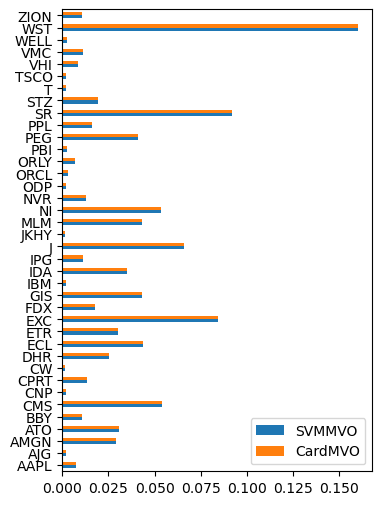

In [32]:
portfolios[(portfolios > 0.001).any(axis =1)].plot.barh(figsize = (4, 6));